## Importando as bibliotecas

In [20]:
import msgpack
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict

from geexhp.conversores import converter_configuracao
from geexhp.modificadores import mod_telescopio, mod_valor_gas, modificador_aleatorio
from geexhp.analisadores import EspectroAnalise
from geexhp.pypsg import PSG

## Primeiro Teste - Carregando arquivo de configuração do HWO para Terra moderna

In [5]:
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))
    
config_df = converter_configuracao(config)

In [7]:
#api_user: str = "https://10.2.180.164/api.php"
psg = PSG(timeout_seconds = 200)

Testing connection to PSG at https://psg.gsfc.nasa.gov/api.php ...
Connected to PSG with success.


In [10]:
config_HWC = config.copy()
mod_telescopio(config_HWC, instrumento = 'HWC')     # HabEx Workforce Camera (HWC)
resultado = psg.run(config_HWC)

In [12]:
spectrum = EspectroAnalise(resultado)
spectrum.converter_para_dataframe()

Wave/freq [um]  Total [I/F apparent albedo]     Noise    Planet
0           0.370000                     0.102022  0.129523  0.102022
1           0.370370                     0.101932  0.130016  0.101932
2           0.370740                     0.101843  0.130330  0.101843
3           0.371111                     0.101752  0.130759  0.101752
4           0.371482                     0.101661  0.132349  0.101661
...              ...                          ...       ...       ...
1578        1.791332                     0.005067  0.485152  0.005067
1579        1.793123                     0.001620  0.487056  0.001620
1580        1.794916                     0.003894  0.489079  0.003894
1581        1.796711                     0.003114  0.491635  0.003114
1582        1.798508                     0.009143  0.487880  0.009143

[1583 rows x 4 columns]

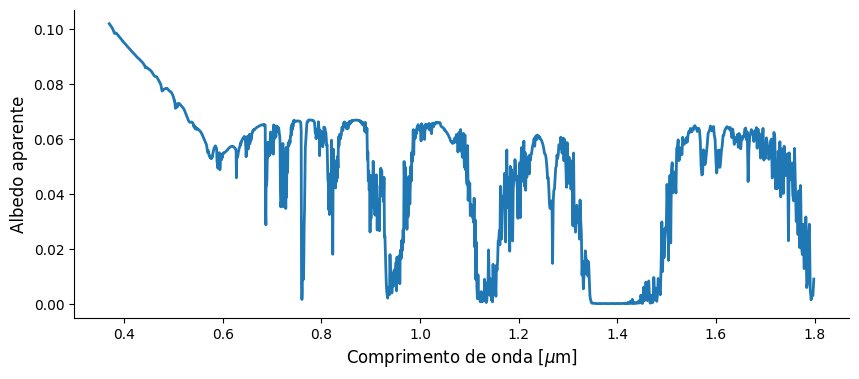

In [13]:
spectrum.plotar_espectro();

In [49]:
## Colocando o HabEx StarShade (SS)

# UV (0.2 to 0.45 um) 
config_SSUV = config.copy()
mod_telescopio(config_SSUV, instrumento = 'SS-UV')    
resultado = psg.run(config_SSUV)
spectrum_SSUV = EspectroAnalise(resultado)
df_SSUV = spectrum_SSUV.converter_para_dataframe()

# visible (0.45 to 1um)
config_SSVis = config.copy()
resultado = psg.run(config_SSVis)
spectrum_SSVis = EspectroAnalise(resultado)
df_SSVis = spectrum_SSVis.converter_para_dataframe()

# infrared (0.975 to 1.8 um)
config_SSNIR = config.copy()
mod_telescopio(config_SSNIR, instrumento = 'SS-NIR')  
resultado = psg.run(config_SSNIR)
spectrum_SSNIR = EspectroAnalise(resultado)
df_SSNIR = spectrum_SSNIR.converter_para_dataframe()

df = pd.concat([df_SSUV, df_SSVis, df_SSNIR])
df.reset_index(drop=True, inplace=True)

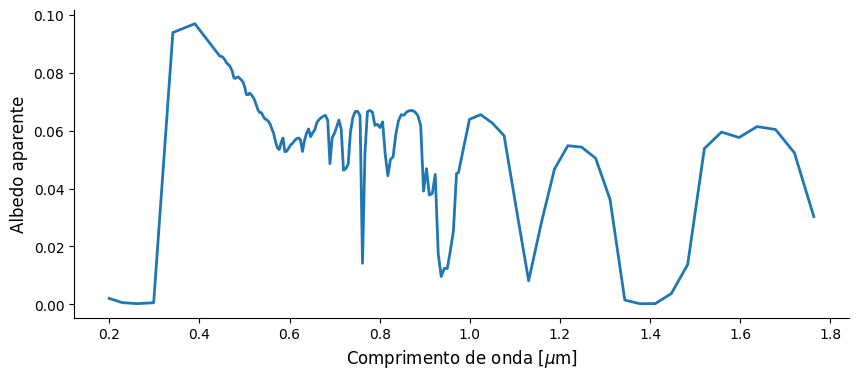

In [62]:
wave_freq = df["Wave/freq [um]"]
total_albedo = df["Total [I/F apparent albedo]"]
erro = df["Noise"]

_, ax = plt.subplots()
ax.plot(wave_freq, total_albedo, color="tab:blue", lw=2)
#ax.errorbar(wave_freq, total_albedo, yerr=erro, fmt="o", capsize=3, color="gray", alpha=0.35, markersize=5)

ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente");

## Teste 2 - Mudando as abundâncias

In [64]:
# Dobrando o valor de O2
config_dobro_O2 = config.copy()
mod_telescopio(config_dobro_O2, instrumento = "HWC") 
mod_valor_gas(config_dobro_O2, "O2", 2)
resultado_dobro_O2 = psg.run(config_dobro_O2)

In [65]:
# Tirando O2 da atmosfera
config_sem_O2 = config.copy()
mod_telescopio(config_sem_O2,  instrumento = "HWC") 
mod_valor_gas(config_sem_O2, "O2", 0)
resultado_sem_O2 = psg.run(config_sem_O2)

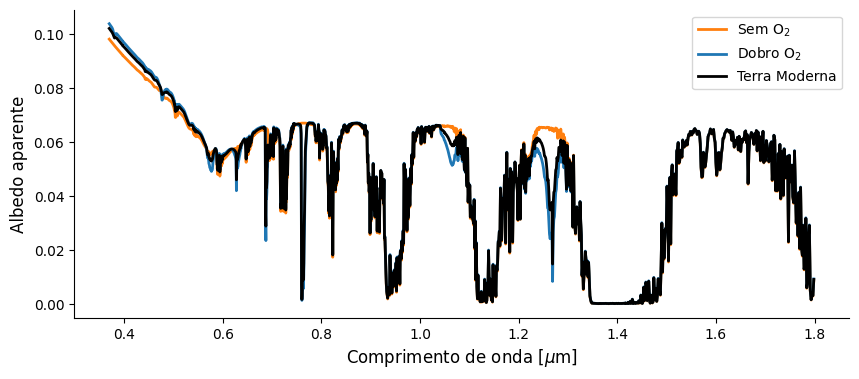

In [66]:
spectrum_dobro_02 = EspectroAnalise(resultado_dobro_O2)
spectrum_sem_02 = EspectroAnalise(resultado_sem_O2)

_, ax = plt.subplots()
spectrum_sem_02.plotar_espectro(ax = ax, label = "Sem O${}_2$", cor_linha = "tab:orange")
spectrum_dobro_02.plotar_espectro(ax = ax, label = "Dobro O${}_2$", cor_linha = "tab:blue")
spectrum.plotar_espectro(ax=ax, label="Terra Moderna", cor_linha = "k")
ax.legend();

## Teste 3 - Modificando a pressão atmosférica (mbar)

In [16]:
# 500 mbar = .5 bar
# O espectro não retornou nada para o dobro e 4x a pressão atmosférica
config_metade_atm = config.copy()
config_metade_atm["ATMOSPHERE-PRESSURE"] = 500
mod_telescopio(config_metade_atm, instrumento = 'HWC') 
resultado_metade_atm = psg.run(config_metade_atm)

config_15_atm = config.copy()
config_15_atm["ATMOSPHERE-PRESSURE"] = 1500
mod_telescopio(config_15_atm, instrumento = 'HWC') 
resultado_15_atm = psg.run(config_15_atm)

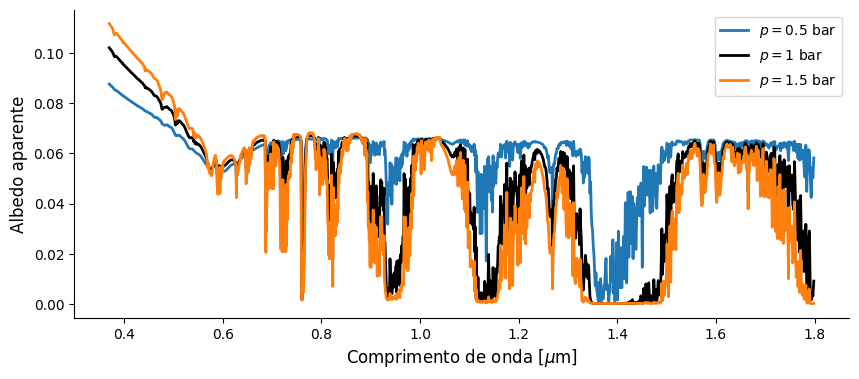

In [17]:
spectrum_metade_atm = EspectroAnalise(resultado_metade_atm)
spectrum_15_atm = EspectroAnalise(resultado_15_atm)

_, ax = plt.subplots()
spectrum_metade_atm.plotar_espectro(ax = ax, label = "$p = 0.5$ bar", cor_linha = "tab:blue")
spectrum.plotar_espectro(ax=ax, label = "$p = 1$ bar", cor_linha = "black")
spectrum_15_atm.plotar_espectro(ax = ax, label = "$p = 1.5$ bar", cor_linha = "tab:orange")
ax.legend();

Quando a pressão atmosférica diminui, é geralmente um indicativo de uma atmosfera mais rarefeita. Em contrapartida, uma pressão atmosférica mais elevada sugere uma atmosfera mais densa e expansiva. A correlação entre a densidade atmosférica e a visibilidade das assinaturas espectrais está intrinsecamente ligada à interação fóton-molécula. Em uma atmosfera densa, as moléculas presentes têm mais oportunidades de interagir com os fótons, resultando em assinaturas espectrais mais pronunciadas. No entanto, quando a atmosfera é mais rarefeita, essas interações diminuem, levando a uma atenuação significativa das assinaturas espectrais.

## Geração de modelos

In [21]:
aleatorio = config.copy()

modificador_aleatorio(aleatorio)
mod_telescopio(aleatorio, instrumento = "HWC")
resultado_random = psg.run(aleatorio)
spectrum_random = EspectroAnalise(resultado_random)

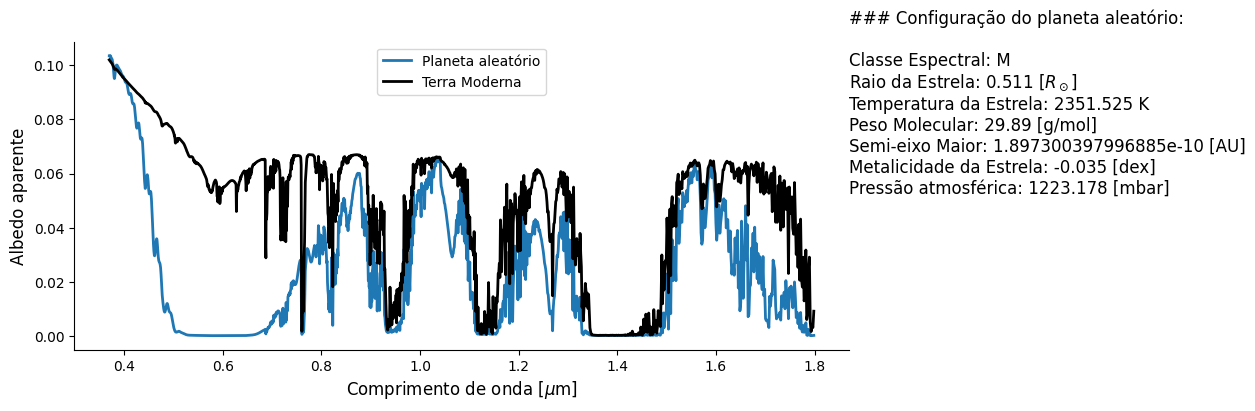

In [22]:
CLASSE_ESPECTRAL = aleatorio['OBJECT-STAR-TYPE']
RAIO_ESTRELA = aleatorio['OBJECT-STAR-RADIUS']
TEMPERATURA_ESTRELA = aleatorio['OBJECT-STAR-TEMPERATURE']
PESO_MOLECULAR = aleatorio['ATMOSPHERE-WEIGHT']
SEMI_EIXO_MAIOR = aleatorio['OBJECT-STAR-DISTANCE']
METALICIDADE_ESTRELA = aleatorio['OBJECT-STAR-METALLICITY']
PRESSAO_ATMO = aleatorio["ATMOSPHERE-PRESSURE"]

_, ax = plt.subplots()

spectrum_random.plotar_espectro(ax = ax, label = "Planeta aleatório")
spectrum.plotar_espectro(ax = ax, cor_linha = "k", label = "Terra Moderna")
plt.legend(loc = "upper center")

texto = ("### Configuração do planeta aleatório:\n\n"
         f"Classe Espectral: {CLASSE_ESPECTRAL}\n"
         f"Raio da Estrela: {RAIO_ESTRELA} [$R_\odot$]\n"
         f"Temperatura da Estrela: {TEMPERATURA_ESTRELA} K\n"
         f"Peso Molecular: {PESO_MOLECULAR} [g/mol]\n"
         f"Semi-eixo Maior: {SEMI_EIXO_MAIOR} [AU]\n"
         f"Metalicidade da Estrela: {METALICIDADE_ESTRELA} [dex]\n"
         f"Pressão atmosférica: {PRESSAO_ATMO} [mbar]")

plt.text(1, 0.8, texto,
         horizontalalignment='left',
         verticalalignment='center',
         transform=plt.gca().transAxes)

plt.show()